In [1]:
import spikeinterface.full as si
from spikeinterface.preprocessing import correct_motion
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

spikeglx_folder = './NPX_FC2407022_exp_g0'
stream_names, stream_ids = si.get_neo_streams('spikeglx',spikeglx_folder)
print(stream_names)
raw_rec = si.read_spikeglx(spikeglx_folder, stream_name='imec0.ap', load_sync_channel=False)
raw_rec.get_probe().to_dataframe()

c:\Users\admin\.conda\envs\si_kilosort\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['imec0.ap', 'nidq', 'imec0.lf']


,x,y,contact_shapes,width,shank_ids,contact_ids
0,0.0,0.0,square,12.0,,e0
1,103.0,0.0,square,12.0,,e1
2,0.0,20.0,square,12.0,,e2
3,103.0,20.0,square,12.0,,e3
4,0.0,40.0,square,12.0,,e4
...,...,...,...,...,...,...
379,103.0,3780.0,square,12.0,,e379
380,0.0,3800.0,square,12.0,,e380
381,103.0,3800.0,square,12.0,,e381
382,0.0,3820.0,square,12.0,,e382


In [2]:
print('Preprocess Real Data, High Pass')
rec3 = si.highpass_filter(recording=raw_rec, freq_min=300.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec3)

rec3 = rec3.remove_channels(bad_channel_ids)
print('Preprocess Real Data, bad_channel_ids', bad_channel_ids)

print('Preprocess Real Data, phase shift')
rec3 = si.phase_shift(rec3)

print('Preprocess Real Data, CAR')
rec3 = si.common_reference(rec3, operator="median", reference="global")

rec = rec3

Preprocess Real Data, High Pass
Preprocess Real Data, bad_channel_ids ['imec0.ap#AP191']
Preprocess Real Data, phase shift
Preprocess Real Data, CAR


In [3]:
print('Saving to kilosort format for later use')
from kilosort import io
dtype = np.int16
filename, N, c, s, fs, probe_path = io.spikeinterface_to_binary(rec, './KS_TEMP2/', data_name='preprocessed.bin', dtype=dtype,chunksize=60000, export_probe=True, probe_name='probe.prb')
from kilosort import run_kilosort
probe = io.load_probe(probe_path)

Saving to kilosort format for later use


In [4]:
settings = {'fs': fs, 'n_chan_bin': c,'nblocks':5,'Th_learned':7,'Th_universal':9}
print('Run Kilosort')
ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = run_kilosort(settings=settings, probe=probe, filename=filename, results_dir='kilosort_def_5block_97')

kilosort.run_kilosort: Kilosort version 4.0.12
kilosort.run_kilosort: Sorting KS_TEMP2\preprocessed.bin
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------


Run Kilosort


kilosort.run_kilosort: Preprocessing filters computed in  2.04s; total  2.15s
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-computing universal templates from data.
100%|██████████| 866/866 [07:03<00:00,  2.04it/s]
kilosort.run_kilosort: drift computed in  428.98s; total  431.15s
kilosort.run_kilosort:  
kilosort.run_kilosort: Extracting spikes using templates
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-computing universal templates from data.
100%|██████████| 866/866 [07:03<00:00,  2.04it/s]
kilosort.run_kilosort: 1792782 spikes extracted in  425.99s; total  857.19s
kilosort.run_kilosort:  
kilosort.run_kilosort: First clustering
kilosort.run_kilosort: ----------------------------------------
100%|██████████| 96/96 [00:41<00:00,  2.31it/s]
kilosort.run_kilosort: 510 clusters found, in  41.87s; total  899.07s
kilosort.run_ki

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
from kilosort.io import save_preprocessing, load_ops
from kilosort.io import load_ops

# outputs saved to results_dir
results_dir = Path('kilosort_def_5block_97')
ops = load_ops(results_dir / 'ops.npy')
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

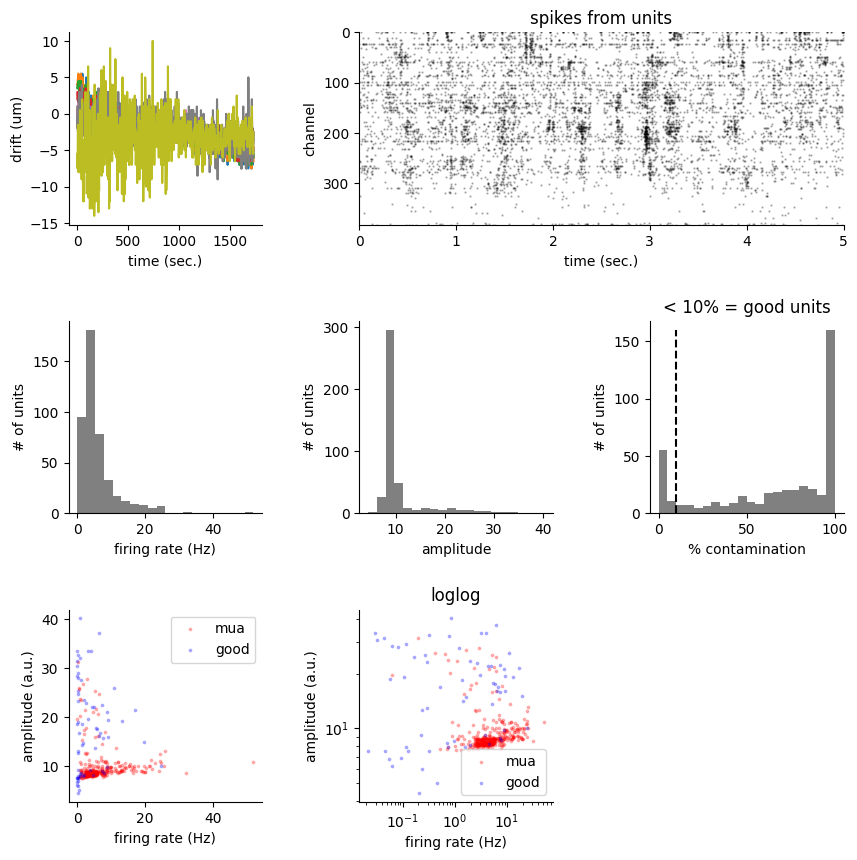

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')